```{index} single: AMPL; AMPL Python API
```
```{index} single: AMPL MP Library
```
```{index} single: application; portfolio
```
```{index} single: application; investment
```
```{index} single: solver; mosek
```

# Markowitz portfolio optimization revisited

In [1]:
# install dependencies and select solver
!pip install -q amplpy numpy pandas

SOLVER_CONIC = "mosek"    ## ipopt, mosek, gurobi, knitro

In [2]:
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["coin", "mosek"],   # modules to install
    license_uuid="default"       # license to use
) # instantiate AMPL object and register notebook magics
from IPython.display import Markdown, HTML
import numpy as np
import matplotlib.pyplot as plt

Please provide a valid license UUID. You can use a free https://ampl.com/ce license.


## Problem description and model formulation

Consider again the [Markowitz portfolio optimization](../05/markowitz_portfolio.ipynb) we presented earlier in Chapter 5. Recall that the matrix $\Sigma$ describes the covariance among the uncertain return rates $r_i$, $i=1,\dots, n$. Since $\Sigma$ is positive semidefinite by definition, it allows for a Cholesky factorization, namely $\Sigma = B B^\top$. We can then rewrite the quadratic constraint as $\|B^\top x \|_2 \leq \gamma$ and thus as $(\gamma, B^\top x) \in \mathcal{L}^{n+1}$ using the Lorentz cone. In this way, we realize that the original portfolio problem we formulated [earlier](../05/markowitz_portfolio.ipynb) is in fact a conic quadratic optimization problem, which can thus be solved faster and more reliably. The optimal solution of that problem was the one with the maximum expected return while allowing for a specific level $\gamma$ of risk. 

However, an investor could aim for a different trade-off between return and risk and formulate a slightly different optimization problem, namely

$$
\begin{align*}
    \max \quad  &  R \tilde{x} + \mu^\top x - \alpha x^\top \Sigma x \\
    \text{s.t.}\quad
    & \sum_{i=1}^n x_i + \tilde{x}  = C  \\
    & \tilde x \geq 0\\
    & x_i \geq 0 & \forall \, i=1,\dots,n. 
\end{align*}
$$

where $\alpha \geq 0$ is a *risk tolerance* parameter that describes the relative importance of return vs. risk for the investor.

The risk, quantified by the variance of the investment return $x^\top \Sigma x = x^\top B^\top B x$, appears now in the objective function as a penalty term. Note that even in this new formulation we have a conic problem since we can rewrite it as

$$
\begin{align*}
    \max \quad  &  R \tilde{x} + \mu^\top x - \alpha s \\
    \text{s.t.}\quad
    & \sum_{i=1}^n x_i + \tilde{x}  = C  \\
    & \| B^\top x\|^2_2 \leq s \\
    & \tilde x \geq 0 \\
    & s \geq 0\\
    & x_i \geq 0 & \forall \, i=1,\dots,n. 
\end{align*}
$$

Solving for all values of $\alpha \geq 0$, one can obtain the so-called **efficient frontier**.

In [3]:
%%writefile markowitz_portfolio_revisited.mod

# Specify the initial capital, the risk tolerance, and the guaranteed return rate. 
param C;
param alpha;
param R;

# Specify the number of assets, their expected return, and their covariance matrix.
param n;
param mu{1..n};
param Sigma{1..n, 1..n};

var xtilde >= 0;
var x{1..n} >= 0;
var s >= 0;
    
maximize Objective:
    sum {i in 1..n} mu[i]*x[i] + R*xtilde - alpha*s;
    
s.t. BoundedVariance:
    sum {i in 1..n, j in 1..n} x[i]*Sigma[i,j]*x[j] <= s;
    
s.t. TotalAssets:
    sum {i in 1..n} x[i] + xtilde == C;
    

Overwriting markowitz_portfolio_revisited.mod


In [4]:
# Specify the initial capital, the risk tolerance, and the guaranteed return rate. 
C = 1
alpha = 0.1
R = 1.05

# Specify the number of assets, their expected return, and their covariance matrix.
n = 3
mu = np.array([1.25, 1.15, 1.35])
Sigma = np.array([[1.5, 0.5, 2], [0.5, 2, 0], [2, 0, 5]])

# If you want to change the covariance matrix Sigma, ensure you input a semi-definite positive one.
# The easiest way to generate a random covariance matrix is first generating a random m x m matrix A 
# and then taking the matrix A^T A (which is always semi-definite positive)
# m = 3
# A = np.random.rand(m, m)
# Sigma = A.T @ A
#
# Moreover, in practive such a matrix A, called factor, can be low-rank,
# see https://docs.mosek.com/modeling-cookbook/qcqo.html#example-factor-model.
# This would provide better numerical properties for the proper conic formulation
#        y=Ax, |y|^2 <= s,
# corresponding to the mathematical formulation above.

def markowitz_revisited(alpha, mu, Sigma):
    
    ampl = AMPL()
    ampl.read("markowitz_portfolio_revisited.mod")

    ampl.param["C"] = C
    ampl.param["alpha"] = alpha
    ampl.param["R"] = R

    ampl.param["n"] = n
    ampl.param["mu"] = mu
    ampl.param["Sigma"] = {
        (i+1, j+1): Sigma[i][j]
        for i in range(n)
        for j in range(n)
    }

    ampl.option["solver"] = SOLVER_CONIC
    ampl.solve()
    
    return ampl

ampl = markowitz_revisited(alpha, mu, Sigma)
xtilde = ampl.get_variable("xtilde").value()
x = ampl.get_variable("x").get_values().to_dict()

display(Markdown(f"**Solver status:** *{ampl.get_value('solve_result')}*"))
display(Markdown(f"**Solution:** $\\tilde x = {xtilde:.3f}$"
                 f"              $x_1 = {x[1]:.3f}$,  $x_2 = {x[2]:.3f}$,  $x_3 = {x[3]:.3f}$"))
display(Markdown(f"**Maximizes objective value to:**"
                 f" ${ampl.get_objective('Objective').value():.2f}$"))

MOSEK 10.0.43: MOSEK 10.0.43: optimal; objective 1.12065217
0 simplex iterations
8 barrier iterations


**Solver status:** *solved*

**Solution:** $\tilde x = 0.283$              $x_1 = 0.478$,  $x_2 = 0.130$,  $x_3 = 0.109$

**Maximizes objective value to:** $1.12$

MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.324999981
0 simplex iterations
8 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.299999995
0 simplex iterations
8 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.251999955
0 simplex iterations
9 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.221333307
0 simplex iterations
8 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.199047619
0 simplex iterations
10 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.180952352
0 simplex iterations
7 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.165238086
0 simplex iterations
8 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.150884338
0 simplex iterations
9 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.138315214
0 simplex iterations
7 barrier iterations
MOSEK 10.0.43:MOSEK 10.0.43: optimal; objective 1.128502403
0 simplex iterations


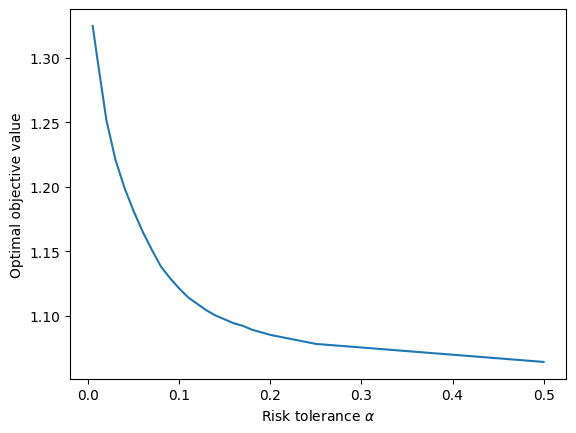

In [5]:
alpha_values = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.25, 0.5]
objective = []

for alpha in alpha_values:
    ampl = markowitz_revisited(alpha, mu, Sigma)
    objective.append(round(ampl.get_objective("Objective").value(), 3))
    
plt.plot(alpha_values, objective)
plt.xlabel(r'Risk tolerance $\alpha$')
plt.ylabel('Optimal objective value')
plt.show()